# Iris Model Training and Deployment Pipeline

In this demo, we will train and deploy a machine learning model using the iris dataset. We will be using MLRun to create the pipeline. This allows for easy containerization and deployment of our pipeline on top of a production-ready Kubernetes cluster.

The full pipeline will do the following:
1. Fetch the dataset and store as a CSV file
2. Train the model and log model/metrics/data via experiment tracking hooks
3. Deploy the model to a real-time endpoint

Once the pipeline is run, we will test the model in real-time via HTTP requests.

### Create Project

In [33]:
import mlrun
from mlrun.runtimes.utils import generate_function_image_name

project = mlrun.get_or_create_project(name="spark-pipeline", context="./")

> 2021-12-14 20:37:48,047 [info] loaded project spark-pipeline from MLRun DB


### Build Docker Image

In [34]:
build = mlrun.new_function(name="build-image", kind="remote-spark")
build.spec.build.commands = ['pip install pyspark']
build.with_spark_service(spark_service="spark")

In [35]:
# UNCOMMENT TO BUILD IMAGE - ONLY NEED TO RUN ONCE
# build.deploy()

In [36]:
image = generate_function_image_name(build)
print(image)

.mlrun/func-spark-pipeline-build-image:latest


### Add Functions to Project

In [37]:
project.set_function(name='get-data', func='components/get_data.py', kind='job', image='mlrun/mlrun')
project.set_function(name='spark-read-csv', func='components/spark_read_csv.py', kind='remote-spark', image=image)

### Add Pipelines to Project

In [38]:
project.set_workflow(name='main', workflow_path='pipelines/training_pipeline.py')

### Save Project

In [39]:
project.save()

In [40]:
!cat project.yaml

kind: project
metadata:
  name: spark-pipeline
  created: '2021-12-14T19:31:48.308000+00:00'
spec:
  functions:
  - url: components/get_data.py
    name: get-data
    kind: job
    image: mlrun/mlrun
  - url: components/spark_read_csv.py
    name: spark-read-csv
    kind: remote-spark
    image: .mlrun/func-spark-pipeline-build-image:latest
  workflows:
  - name: main
    path: pipelines/training_pipeline.py
    engine: null
  artifacts: []
  source: ''
  subpath: ''
  origin_url: ''
  desired_state: online
  owner: nick
  disable_auto_mount: false
status:
  state: online


### Run Pipeline with Parameters

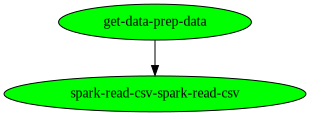

uid,start,state,name,results,artifacts
...a728cd9f,Dec 14 20:38:16,completed,spark-read-csv-spark_read_csv,,df_sample
...ec1e8f0c,Dec 14 20:37:59,completed,get-data-prep_data,num_rows=150,cleaned_data


In [41]:
run_id = project.run(
    name="main",
    arguments={
        "source_url" : "https://s3.wasabisys.com/iguazio/data/iris/iris.data.raw.csv",
        "label_column" : "label",
    },
    watch=True
)